----------------

```{admonition} Learning Objectives
* Create a grid to bin features
* Bin features using the grid
* Display kernel density estimation results and export resulting raster
```
```{admonition} Review
* [Geospatial Vector Data](c_vectors.md)
* [Geospatial Raster Data](c_rasters.md)
* [Attributes & Indexing for Vector Data](e_attributes.md)
* [Creating Geospatial Vector Data](e_new_vectors.md)
```

----------------

# Point Density Measures - Point Counts & Kernel Density

Summary operations are useful for aggregating data, whether it be for analyzing overall trends or visualizing concentrations of data. Summarizing allows for effective analysis and communication of the data as compared to simply looking at or displaying points, lines, and polygons on a map.

This chapter will explore two summary operations that highlight concentrations of data: count points in a rectangular or hexagonal grid or by polygon and kernel density.

**Setup**

First, we will import the necessary modules (click the + below to show code cell).

In [1]:
# Import modules
import geopandas as gpd
import geoplot as gplt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import Affine
from scipy import stats
from shapely.geometry import Polygon, box
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

We will utilize shapefiles of San Francisco Bay Area county boundaries and wells within the Bay Area and the surrounding 50 km. We will load in the data and reproject the data (click the + below to show code cell).

In [2]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
counties = gpd.read_file("../_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Well locations
# Source: https://gis.data.ca.gov/datasets/3a3e681b894644a9a95f9815aeeeb57f_0?geometry=-123.143%2C36.405%2C-119.230%2C37.175
# Modified by author so that only the well locations within the counties and the surrounding 50 km were kept
wells = gpd.read_file("../_static/e_vector_shapefiles/sf_bay_wells_50km/sf_bay_wells_50km.shp")

# Reproject data to NAD83(HARN) / California Zone 3
# https://spatialreference.org/ref/epsg/2768/
proj = 2768
counties = counties.to_crs(proj)
wells = wells.to_crs(proj)

# Create a column that assigns each well a number
wells["Well_ID"] = np.arange(wells.shape[0])

## Count Points in Rectangular or Hexagonal Grid or by Polygon

To summarize by grid, we create a new polygon layer consisting of a grid and overlay on another feature. We can summarize an aspect of that feature within each cell of the grid. The polygon layer commonly consists of a fishnet (rectangular cells), but using hexagons as a grid is becoming increasingly widespread.

Let's define a function that will create a grid of either rectangles or hexagons of a specified side length.

In [3]:
def create_grid(feature, shape, side_length):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))


    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

We will illustrate this methodology by counting the number of well points within each cell of the grid. There are two different ways we can accomplish this methodology, both with advantages and disadvantages.

To begin, we will set some global parameters for both examples.

In [4]:
# Set side length for cells in grid
# This is dependent on projection chosen as length is in units specified in projection
side_length = 5000

# Set shape of grid
shape = "hexagon"
# shape = "rectangle"

### Method 1 - Group by

This method involves using spatial joins to allocate each point to the cell in which it resides. All the points within each cell are subsequently grouped together and counted.

First, we will create a grid over the Bay Area.

Text(0.5, 1.0, 'San Francisco Bay Area - Boundaries, Wells, and Grids')

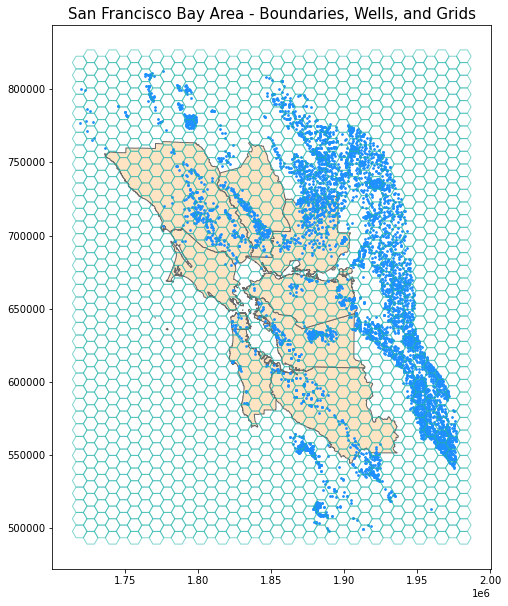

In [5]:
# Create grid
bay_area_grid = create_grid(feature = wells, shape = shape, side_length = side_length)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)
bay_area_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

# Set title
ax.set_title('San Francisco Bay Area - Boundaries, Wells, and Grids', fontdict = {'fontsize': '15', 'fontweight' : '3'})

Next, we will conduct a spatial join for each well point, essentially assigning it to a cell. We can add a field with a value of `1`, group all the wells in a cell, and aggregate **(sum)** all those `1` values to get the total number of wells in a cell.

In [6]:
# Perform spatial join, merging attribute table of wells point and that of the cell with which it intersects
# op = "intersects" also counts those that fall on a cell boundary (between two cells)
# op = "within" will not count those fall on a cell boundary
wells_cell = gpd.sjoin(wells, bay_area_grid, how = "inner", op = "intersects")

# Remove duplicate counts
# With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
wells_cell = wells_cell.drop_duplicates(subset = ['Well_ID']).reset_index(drop = True)

# Set field name to hold count value
count_field = "Count"

# Add a field with constant value of 1
wells_cell[count_field] = 1

# Group GeoDataFrame by cell while aggregating the Count values
wells_cell = wells_cell.groupby('Grid_ID').agg({count_field:'sum'})

# Merge the resulting grouped dataframe with the grid GeoDataFrame, using a left join to keep all cell polygons
bay_area_grid = bay_area_grid.merge(wells_cell, on = 'Grid_ID', how = "left")

# Fill the NaN values (cells without any points) with 0
bay_area_grid[count_field] = bay_area_grid[count_field].fillna(0)

# Convert Count field to integer
bay_area_grid[count_field] = bay_area_grid[count_field].astype(int)

# Display grid attribute table
display(bay_area_grid)

,geometry,Grid_ID,Count
0,"POLYGON ((1724272.398 497763.821, 1721772.398 ...",0,0
1,"POLYGON ((1724272.398 506424.075, 1721772.398 ...",1,0
2,"POLYGON ((1724272.398 515084.329, 1721772.398 ...",2,0
3,"POLYGON ((1724272.398 523744.583, 1721772.398 ...",3,0
4,"POLYGON ((1724272.398 532404.837, 1721772.398 ...",4,0
...,...,...,...
1381,"POLYGON ((1986772.398 787882.331, 1984272.398 ...",1381,0
1382,"POLYGON ((1986772.398 796542.585, 1984272.398 ...",1382,0
1383,"POLYGON ((1986772.398 805202.839, 1984272.398 ...",1383,0
1384,"POLYGON ((1986772.398 813863.093, 1984272.398 ...",1384,0


We can plot the data to see how it looks.

Text(0.5, 1.0, 'San Francisco Bay Area - Binning Well Points')

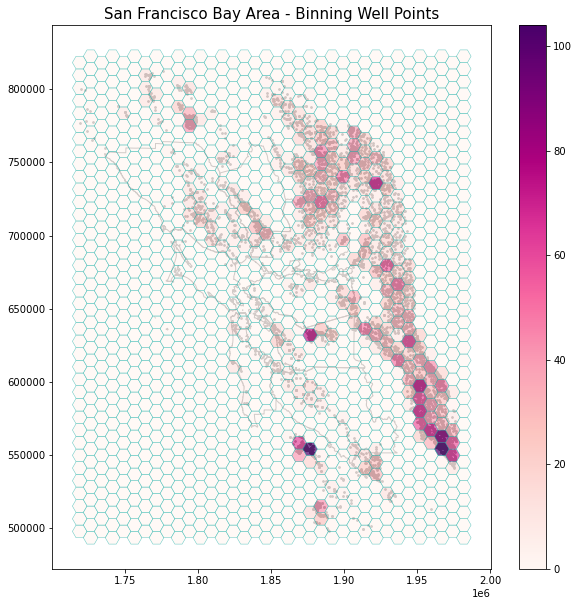

In [7]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
wells.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 3)
bay_area_grid.plot(ax = ax, column = "Count", cmap = "RdPu", edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.70, legend = True)

# Set title
ax.set_title('San Francisco Bay Area - Binning Well Points', fontdict = {'fontsize': '15', 'fontweight' : '3'})

The advantage of this method is that it is pretty fast. To verify that all points have been counted once, we can check the aggregate of all the point sums for each cell.

In [8]:
# Check total number of well points counted and compare to number of well points in input data
print("Total number of well points counted: {}\nNumber of well points in input data: {}".format(sum(bay_area_grid.Count), len(wells)))

Total number of well points counted: 6037
Number of well points in input data: 6037


### Method 2 - Iterate through each feature

This second method is slightly more intuitive, but it can take a long time to run. We will use a subset of the input data--those that fall within Santa Clara County--to illustrate this example. We will first subset our data to Santa Clara County (click the + below to show code cell).

In [9]:
# Select the Santa Clara County boundary
sc_county = counties[counties["coname"] == "Santa Clara County"]

# Subset the GeoDataFrame by checking which wells are within Santa Clara County
sc_county_wells = wells[wells.within(sc_county.geometry.values[0])]

Next, we will create a grid over Santa Clara County.

Text(0.5, 1.0, 'Santa Clara County - Boundaries, Wells, and Grids')

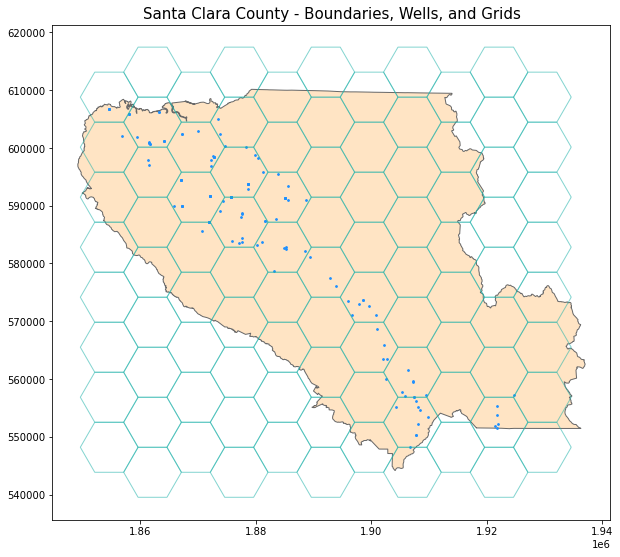

In [10]:
# Create grid
sc_county_grid = create_grid(feature = sc_county_wells, shape = shape, side_length = side_length)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
sc_county.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
sc_county_wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)
sc_county_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

# Set title
ax.set_title('Santa Clara County - Boundaries, Wells, and Grids', fontdict = {'fontsize': '15', 'fontweight' : '3'})

We iterate through each cell in the grid and set a counter for each cell. We iterate through each well point and see if it is within (or intersects) the cell. If it is, the counter is increased by 1, and the feature is "discarded" so that it won't be counted again (resolving the issue of a point falling on the boundary between two cells).

In [11]:
# Create empty list used to hold count values for each grid
counts_list = []

# Create empty list to hold index of points that have already been matched to a grid
counted_points = []

# Iterate through each cell in grid
for i_1 in range(0, sc_county_grid.shape[0]):

    # Get a cell by index
    cell = sc_county_grid.iloc[[i_1]]

    # Reset index of cell to 0
    cell = cell.reset_index(drop = True)

    # Set point count to 0
    count = 0

    # Iterate through each feature in wells dataset
    for i_2 in range(0, sc_county_wells.shape[0]):

        # Check if index of point is in list of indices whose points have already been matched to a grid and counted
        if i_2 in counted_points:

            # If already counted, skip remaining statements in loop and start at top of loop
            continue

        # Otherwise, continue with remaining statements
        else:
            pass

        # Get a well point by index
        well = sc_county_wells.iloc[[i_2]]

        # Reset index of well point (to 0) to match the index-reset cell
        well = well.reset_index(drop = True)

        # Check if well intersects the cell
        # Best to use intersects instead of within or contains, as intersect will count points that fall exactly on the cell boundaries
        # Points that fall exactly on a cell boundary (between two cells) will be allocated to the first of the two cells called in script
        criteria_met = well.intersects(cell)[0]

        # If preferred, can check if well is within cell or if cell contains well
        # Both statements do the same thing
        # criteria_met = well.within(cell)[0]
        # criteria_met = cell.contains(well)[0]

        # Check if criteria has been met (True)
        if criteria_met:

            # If True, increase counter by 1 for the cell
            count += 1

            # Add index of counted point to the list
            counted_points.append(i_2)

        # Otherwise, criteria is not met (False)
        else:
            pass

    # Add total count for that cell to the list of counts
    counts_list.append(count)

# print(counts_list)

# Add a new column to the grid GeoDataFrame with the list of counts for each cell
sc_county_grid['Count'] = pd.Series(counts_list)

# Display grid attribute table
display(sc_county_grid)

,geometry,Grid_ID,Count
0,"POLYGON ((1859618.426 548178.942, 1857118.426 ...",0,0
1,"POLYGON ((1859618.426 556839.196, 1857118.426 ...",1,0
2,"POLYGON ((1859618.426 565499.450, 1857118.426 ...",2,0
3,"POLYGON ((1859618.426 574159.704, 1857118.426 ...",3,0
4,"POLYGON ((1859618.426 582819.958, 1857118.426 ...",4,0
...,...,...,...
88,"POLYGON ((1934618.426 574159.704, 1932118.426 ...",88,0
89,"POLYGON ((1934618.426 582819.958, 1932118.426 ...",89,0
90,"POLYGON ((1934618.426 591480.212, 1932118.426 ...",90,0
91,"POLYGON ((1934618.426 600140.466, 1932118.426 ...",91,0


We can check to make sure all well points in Santa Clara County were counted.

In [12]:
# Check total number of well points counted and compare to number of well points in input data
print("Total number of well points counted: {}\nNumber of well points in input data: {}".format(sum(counts_list), len(sc_county_wells)))

Total number of well points counted: 136
Number of well points in input data: 136


Finally, we can plot the data.

Text(0.5, 1.0, 'Santa Clara County - Binning Well Points')

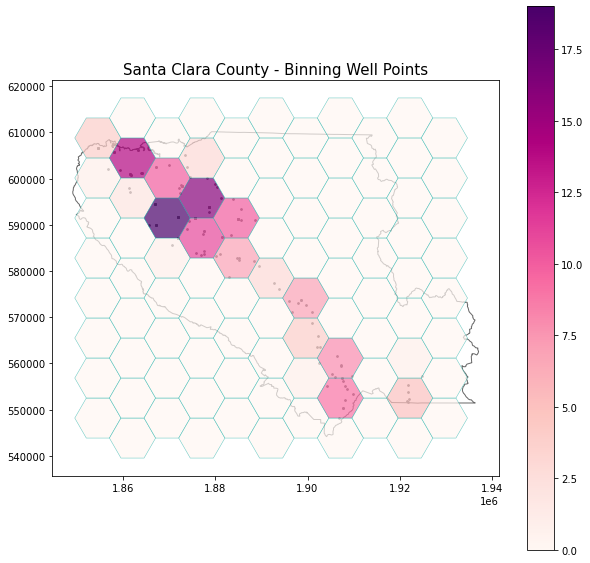

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
sc_county.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
sc_county_wells.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 3)
sc_county_grid.plot(ax = ax, column = "Count", cmap = "RdPu", edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.70, legend = True)

# Set title
ax.set_title('Santa Clara County - Binning Well Points', fontdict = {'fontsize': '15', 'fontweight' : '3'})

## Kernel Density Estimation

Kernel density estimation (KDE) visualizes concentrations points or polylines. It calculates a magnitude per unit area, providing the density estimate of features within a specified neighborhood surrounding each feature. [^esri_kernel], [^bolstad]

A kernel function is used to fit a smooth surface to each feature. One of the most common types of kernels is the Gaussian kernel, which is a normal density function. Other types of kernel functions can be used, and the type affects the influence of surrounding points on a location's density estimate as the points' distances increase from that location. These kernels' functions vary in shapes and characteristics, such as where the function peaks, how pointed the peak is, and how fast the peak is reached with distance. [^esri_kernel], [^bolstad]

In addition to specifying a kernel, the bandwith can also be specified. This parameter defines how spread out the kernel is. A lower bandwith allows points far away from a location to affect the density estimate at that location, whereas with a higher bandwith, only close points have influence. [^esri_kernel], [^bolstad]

Individual density functions based on a specified kernel are plotted for each feature. Then, individual density function values at a location are aggregated to produce the KDE value at that location, and this is repeated across the entire point or polyline extent. The final KDE result is a raster depicting the sum of all individual density functions. [^esri_kernel], [^bolstad]

For more information on KDE, check out [this visualization](https://mathisonian.github.io/kde/).

We will demonstrate two ways to perform kernel density estimation. The first way allows us to quickly visualize the KDE. The second way also allows us to export and save a KDE raster for additional analysis.

```{tip} We are intentionally keeping the well points beyond (but within 50 km) of the Bay Area boundaries. This provides a buffer to ensure that the KDE for wells data near the boundaries is not inadvertently influenced by these artificial county boundaries. Once KDE is run, the result can be clipped to the Bay Area boundaries (which we do in the first method).
```

### Method 1 - Display

This method uses `geoplot`, a high-level plotting library for geospatial data that complements `matplotlib`. For more information on `geoplot`, check out the [documentation](https://residentmario.github.io/geoplot/index.html).

/home/mmann1123/anaconda3/envs/pygisbookgw/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/mmann1123/anaconda3/envs/pygisbookgw/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'San Francisco Bay Area - Kernel Density Estimation for Wells')

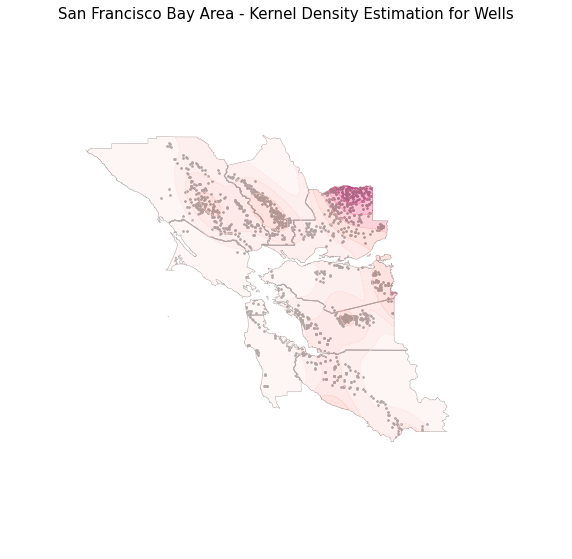

In [14]:
# Set projection to WGS 84 and reproject data
proj_wgs = 4326
counties_wgs = counties.to_crs(proj_wgs)
wells_wgs = wells.to_crs(proj_wgs)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
wells_wgs.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 3)
gplt.kdeplot(wells_wgs, cmap = "RdPu", shade = True, clip = counties_wgs, thresh = 0, ax = ax, alpha = 0.5)

# Set title
ax.set_title('San Francisco Bay Area - Kernel Density Estimation for Wells', fontdict = {'fontsize': '15', 'fontweight' : '3'})

### Method 2 - Display and export with `scikit-learn`

This method uses `scikit-learn` to visualize and export the KDE result. We are able to specify and change various estimator parameters. Examples include:
* kernel type
* [metric (how distances from a location are calculated)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)
* [algorithm (how to quickly identify neighboring points instead of performing time and resource intensive brute force)](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms)

For further reading, check out the [`scikit-learn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity) and the [associated example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html#sphx-glr-auto-examples-neighbors-plot-species-kde-py).

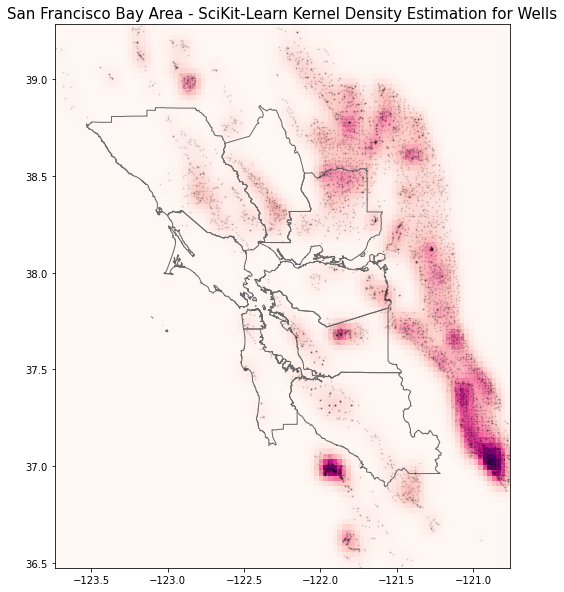

In [15]:
# Get X and Y coordinates of well points
x_sk = wells_wgs["geometry"].x
y_sk = wells_wgs["geometry"].y

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = wells_wgs.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 0.04, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

# Plot data
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.imshow(np.rot90(Z_sk), cmap = "RdPu", extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.1)
counties_wgs.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
ax.set_title('San Francisco Bay Area - SciKit-Learn Kernel Density Estimation for Wells', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

We can export the raster if necessary.

In [16]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

In [17]:
# Export raster
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = proj_wgs, filename = "../temp/bay-area-wells_kde_sklearn.tif")

There are a few other ways to compute KDE in Python. This [article](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/) reviews and compares all these implementations.

[^esri_kernel]: [How Kernel Density works, Esri](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-kernel-density-works.htm)
[^bolstad]: GIS Fundamentals: A First Text on Geographic Information Systems, 5th ed., Paul Bolstad